In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, rand
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import hash, col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, abs

In [ ]:
# Step 1: Initialize Spark Session
#spark = SparkSession.builder \
 #   .appName("MovieRecommendation") \
 #   .getOrCreate()

In [2]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.5'
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [69.0 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,374 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu 

In [3]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkDates").getOrCreate()

In [4]:
# Step 2: Load the dataset (replace with your actual dataset path)

df = spark.read.json("/content/movie_results.json")

In [61]:
# Step 3: Data Cleaning & Filtering
# Step 2: Data Preprocessing

df_filtered = df.select("id", "title", "vote_average", "vote_count").filter(
    (col("vote_average").isNotNull()) & (col("vote_count") >= 50)
)
    # Check the first few rows of the filtered data
df_filtered.show(5)

+-------+--------------------+------------+----------+
|     id|               title|vote_average|vote_count|
+-------+--------------------+------------+----------+
| 950396|           The Gorge|       7.775|      1813|
|1126166|         Flight Risk|       6.086|       429|
|1064213|               Anora|       7.066|      1601|
| 762509|Mufasa: The Lion ...|         7.5|      1601|
|1241982|             Moana 2|         7.2|      1809|
+-------+--------------------+------------+----------+
only showing top 5 rows



In [62]:
# Step 3: Simulate Users for ALS Model
# Create user_id by hashing the movie_id to ensure overlap and make it positive
df_filtered = df_filtered.withColumn("user_id", abs((hash("id") % 1000)).cast(IntegerType()))

# Check the first few rows to ensure the user_id is created
df_filtered.select("user_id", "id", "vote_average").show(5)

+-------+-------+------------+
|user_id|     id|vote_average|
+-------+-------+------------+
|    610| 950396|       7.775|
|    671|1126166|       6.086|
|    860|1064213|       7.066|
|    718| 762509|         7.5|
|    579|1241982|         7.2|
+-------+-------+------------+
only showing top 5 rows



In [63]:
# Step 4: Prepare Data for ALS (ALS expects columns: user_id, movie_id, rating)
# Step 4: Prepare Data for ALS (ALS expects columns: user_id, movie_id, rating)
df_ratings = df_filtered.withColumnRenamed("vote_average", "rating") \
                        .select("user_id", "id", "rating")

In [64]:
import random

# Get distinct users
users = df_ratings.select("user_id").distinct().collect()

# Randomly shuffle the users to get a mix of train and test users
random.seed(42)
random.shuffle(users)

# Split the users into training (80%) and testing (20%) with some overlap
train_users = users[:int(0.8 * len(users))]  # 80% for training
test_users = users[int(0.7 * len(users)):]   # 20% for testing (with overlap from 70% onward)

# Create lists of user_ids for train and test sets
train_user_list = [user['user_id'] for user in train_users]
test_user_list = [user['user_id'] for user in test_users]

# Filter original data for train and test based on users
train_data = df_ratings.filter(df_ratings["user_id"].isin(train_user_list))
test_data = df_ratings.filter(df_ratings["user_id"].isin(test_user_list))

# Manually ensure overlap: Add some random user-movie pairs from the test set to the train set
overlap_size = 100  # Number of overlapping pairs
overlap_pairs = test_data.orderBy("user_id", "id").limit(overlap_size)

# Merge the overlap pairs with the train_data
train_data_with_overlap = train_data.union(overlap_pairs)

# Verify overlap again
train_pairs = train_data_with_overlap.select("user_id", "id").distinct().collect()
test_pairs = test_data.select("user_id", "id").distinct().collect()

train_set = set([(row['user_id'], row['id']) for row in train_pairs])
test_set = set([(row['user_id'], row['id']) for row in test_pairs])

# Find the overlap between train and test sets
overlap = train_set.intersection(test_set)
print(f"Overlapping user-movie pairs: {len(overlap)}")


Overlapping user-movie pairs: 717


In [65]:
# Step 1: Perform inner join between df_ratings and df_filtered on movie 'id'
common_movies = df_ratings.join(df_filtered, 'id', 'inner')

# Step 2: Resolve column name ambiguity
# Since both df_ratings and df_filtered have 'user_id', let's rename 'user_id' in df_filtered
df_filtered = df_filtered.withColumnRenamed('user_id', 'movie_user_id')

# Join again after renaming to avoid ambiguity
common_movies = df_ratings.join(df_filtered, 'id', 'inner')

# Step 3: Select only relevant columns
common_movies = common_movies.select(
    'user_id', 'title', 'rating', 'vote_average', 'vote_count'
)

# Step 4: Show the common movies
common_movies.show(10)

+-------+--------------------+------+------------+----------+
|user_id|               title|rating|vote_average|vote_count|
+-------+--------------------+------+------------+----------+
|    610|           The Gorge| 7.775|       7.775|      1813|
|    671|         Flight Risk| 6.086|       6.086|       429|
|    860|               Anora| 7.066|       7.066|      1601|
|    718|Mufasa: The Lion ...|   7.5|         7.5|      1601|
|    579|             Moana 2|   7.2|         7.2|      1809|
|    328|Sonic the Hedgehog 3|   7.7|         7.7|      2123|
|    599|Captain America: ...| 6.156|       6.156|       967|
|      2|                Flow| 8.298|       8.298|      1461|
|    660|              Amaran|   7.4|         7.4|       188|
|    431|           Mickey 17| 7.039|       7.039|       384|
+-------+--------------------+------+------------+----------+
only showing top 10 rows



In [66]:
# Step 5: Analyzing the ratings
# Find the average rating per movie
avg_ratings = common_movies.groupBy('title').agg({'rating': 'avg'}).withColumnRenamed('avg(rating)', 'avg_rating')
avg_ratings.show(10)

# Step 6: Recommend top 5 movies based on highest average rating
top_movies = avg_ratings.orderBy(col('avg_rating').desc()).limit(5)
top_movies.show()

+--------------------+----------+
|               title|avg_rating|
+--------------------+----------+
|Raya and the Last...|     7.841|
|Penguins of Madag...|     6.525|
|            Warcraft|      6.38|
|            Poseidon|     5.856|
|     My Name Is Khan|       8.0|
|  The Last Airbender|     4.637|
|My Cousin the Sex...|     6.938|
|          The Ritual|     6.257|
|Before I Go to Sleep|       6.5|
|    The Last Warrior|       6.9|
+--------------------+----------+
only showing top 10 rows

+--------------------+----------+
|               title|avg_rating|
+--------------------+----------+
|                Nude|       9.5|
|            Succubus|       9.5|
|           Kill Shot|     9.201|
|The Shawshank Red...|     8.708|
|       The Godfather|     8.689|
+--------------------+----------+



In [67]:
print(f"Train data user-movie pairs count: {train_user_movie_pairs.count()}")
print(f"Test data user-movie pairs count: {test_user_movie_pairs.count()}")

Train data user-movie pairs count: 5676
Test data user-movie pairs count: 614


In [68]:
# Step 6: Build ALS Model
als = ALS(rank=10, maxIter=10, regParam=0.1, userCol="user_id", itemCol="id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(train_data)

Total predictions: 669


In [69]:
# If there are no predictions, print a warning
# Step 9: Show Prediction Data
print(f"Total predictions: {predictions.count()}")

# Corrected column names: Use 'id' for movie_id instead of 'movie_id'
predictions.select("id", "user_id", "rating", "prediction").show(10, truncate=False)

Total predictions: 669
+------+-------+------+----------+
|id    |user_id|rating|prediction|
+------+-------+------+----------+
|22970 |757    |6.629 |6.5869927 |
|167666|416    |7.8   |7.763016  |
|14324 |674    |4.8   |4.768759  |
|385128|703    |7.056 |7.0149903 |
|11025 |817    |6.168 |6.126472  |
|919873|634    |5.051 |5.0146084 |
|118340|450    |7.905 |7.860823  |
|677638|638    |7.8   |7.7515097 |
|776835|63     |6.9   |6.852777  |
|65    |1      |7.137 |7.095564  |
+------+-------+------+----------+
only showing top 10 rows



In [70]:
# Step 10: Evaluate Model Performance
if predictions.count() > 0:
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")
else:
    print("RMSE cannot be computed as no predictions were generated.")

Root Mean Squared Error (RMSE): 0.042745036353331246


In [72]:
print(df_filtered.columns)

['id', 'title', 'vote_average', 'vote_count', 'movie_user_id']


In [74]:
df_ratings.columns

['user_id', 'id', 'rating']

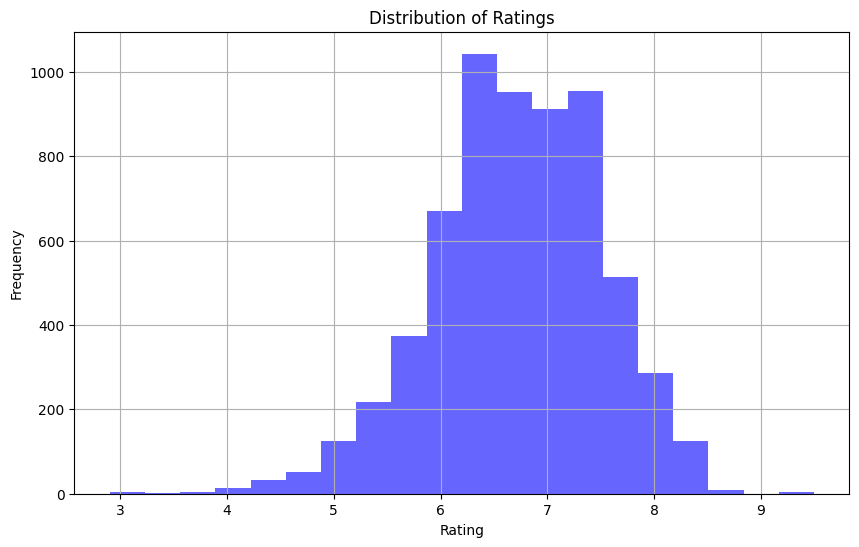

In [75]:
import matplotlib.pyplot as plt

# Convert the DataFrame to pandas for visualization
df_pandas = df_ratings.toPandas()

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['rating'], bins=20, alpha=0.6, color='blue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [80]:
from pyspark.sql.functions import col, explode

# Function to get movie recommendations
def get_movie_recommendations(user_id, num_recommendations=5):
    # Get the top N movie recommendations for the given user
    user_recs = model.recommendForAllUsers(num_recommendations)

    # Filter for the specific user
    user_recs = user_recs.filter(col("user_id") == user_id)

    # Explode the recommendations array to get each movie_id and rating separately
    user_recs_flat = user_recs.withColumn("recommendation", explode(col("recommendations"))) \
                               .select("user_id", "recommendation.id", "recommendation.rating")

    # Join with the movie details (from df_filtered) to get the titles, vote_average, etc.
    movie_details = df_filtered.select("id", "title", "vote_average", "vote_count")

    # Join user recommendations with movie details on 'id' (movie ID)
    recommendations_with_details = user_recs_flat.join(movie_details, user_recs_flat.id == movie_details.id, "inner")

    # Show the top N recommendations with movie details (title, rating, vote_average, etc.)
    recommendations_with_details.select("title", "rating", "vote_average", "vote_count").show(num_recommendations)

# Example usage: Get top 5 recommendations for user with user_id = 1
get_movie_recommendations(1)



+--------------------+---------+------------+----------+
|               title|   rating|vote_average|vote_count|
+--------------------+---------+------------+----------+
|New Gods: Nezha R...|   8.0311|       8.078|       449|
|        Spider-Man 2| 7.245687|       7.288|     15347|
|              8 Mile| 7.095563|       7.137|      7369|
|              Legend|7.0150337|       7.056|      3932|
|Confessions of a ...|6.6611004|         6.7|      1156|
+--------------------+---------+------------+----------+

